<a href="https://colab.research.google.com/github/Jupramirez/Project-with-neural-networks/blob/main/FunctionalLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Conexión con Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProyectoGrado/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1yUdvwym8e9JS9URAVbv_nnrPpUuGQFFy/ProyectoGrado/ProyectoTesis_PC_Esclavo


### Importación de librerias

In [ ]:
!pip install openpyxl==3.0.9

In [ ]:
!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose

In [ ]:
import scripts.dataTensor as dtensor
import scripts.graficar as gf
import scripts.elnan as en
import scripts.norm as norm
import scripts.corr as corr
import scripts.indicadoresFinal as entries

In [ ]:
# Importar las librerias
import numpy as np
import scipy
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
import copy
import gc

import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers, losses, initializers, regularizers

from sklearn import preprocessing
import os
from shutil import rmtree

Libreria TA para indicadores

In [ ]:
# Libreria para los indicadores tecnicos
try:
  !pip install ta
except:
  !pip install --upgrade ta
  print("Ya se encuentra instalada esta biblioteca")

In [ ]:
import ta

Libreria Ta-lib para indicadores

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3721    0  3721    0     0   3202      0 --:--:--  0:00:01 --:--:--  3204
100  503k  100  503k    0     0   175k      0  0:00:02  0:00:02 --:--:--  331k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3753    0  3753    0     0   3280      0 --:--:--  0:00:01 --:--:--  3280
100  406k  100  406k    0     0   150k      0  0:00:02  0:00:02 --:--:--  298k



## Preprocesamiento de datos

### Carga de Dataset

In [ ]:
# Conversion de excel a csv
read_file=pd.read_excel(r'DatosCompletos.xlsx') # Lectura del excel
rutaCsv = r"DatosCompletos.csv" # Ruta donde quedara el csv
read_file.to_csv(rutaCsv, index = None, header=True) # Convierte a csv
data = pd.read_csv(rutaCsv) # lectura de csv y lo deja en la ruta
dataset = data.loc[:,'Volumen':'PrecioMenor'] # Corta parte del dataset

In [ ]:
dpo = ta.trend.dpo(dataset['PrecioCierre'], 20,False) # Detrended price oscillator

In [ ]:
dema = talib.DEMA(dataset['PrecioCierre'],30) # Double exponential moving average

In [ ]:
bbands = ta.volatility.bollinger_hband(dataset['PrecioCierre']) # bollinger bands superior

In [ ]:
bbands_low = ta.volatility.bollinger_lband(dataset['PrecioCierre']) #bollinger bands low

In [ ]:
obv = ta.volume.on_balance_volume(dataset['PrecioCierre'],dataset['Volumen']) # On - balance Volumen

In [ ]:
nvi = ta.volume.negative_volume_index(dataset['PrecioCierre'],dataset['Volumen']) # Negative volume index

In [ ]:
cci = ta.trend.cci(dataset['PrecioMayor'],dataset['PrecioMenor'],dataset['PrecioCierre']) # Commodity chanel index

In [ ]:
data

,Nemotecnico,fecha,Cantidad,Volumen,PrecioCierre,PrecioMayor,PrecioMedio,PrecioMenor
0,BCOLOMBIA,2001-01-04,13946,10668690,765,765,765.00,765
1,BCOLOMBIA,2001-01-05,4111,3083250,765,0,750.00,0
2,BCOLOMBIA,2001-01-09,22800,17798000,780,780,780.61,780
3,BCOLOMBIA,2001-01-10,88804,70517102,800,800,794.08,780
4,BCOLOMBIA,2001-01-11,270386,216308800,800,800,800.00,800
...,...,...,...,...,...,...,...,...
4331,BCOLOMBIA,2018-12-21,378776,11783960460,31480,31480,31110.63,30000
4332,BCOLOMBIA,2018-12-24,5033,150990000,30000,30000,30000.00,30000
4333,BCOLOMBIA,2018-12-26,30882,927504960,30800,30980,30033.84,30000
4334,BCOLOMBIA,2018-12-27,59657,1819839820,30640,30800,30505.05,30320


### Indicadores

In [ ]:
# Llamado de los indicadores
dataset['adx'] = entries.get_adx(dataset['PrecioMayor'],dataset['PrecioMenor'],dataset['PrecioCierre'],14)[2]
dataset['moment'] = entries.get_moment(dataset['PrecioCierre'])
dataset['macd'] = entries.get_macd(dataset['PrecioCierre'])[0]
dataset['rsi'] = entries.get_rsi(dataset['PrecioCierre'],14)[2]
dataset['estocastic_D'] = entries.get_estocastic(dataset['PrecioCierre'],14,7)[2]
dataset['estocastic_K'] = entries.get_estocastic(dataset['PrecioCierre'],14,7)[1]
dataset['ado'] = entries.get_ado(dataset['PrecioCierre'],dataset['PrecioMenor'],dataset['PrecioMayor'],dataset['Volumen'])
dataset['dpo'] = dpo
dataset['dema'] = dema
dataset['bbands'] = bbands
dataset['lbands'] = bbands_low
dataset['obv'] = obv
dataset['nvi'] = nvi
dataset['cci'] = cci

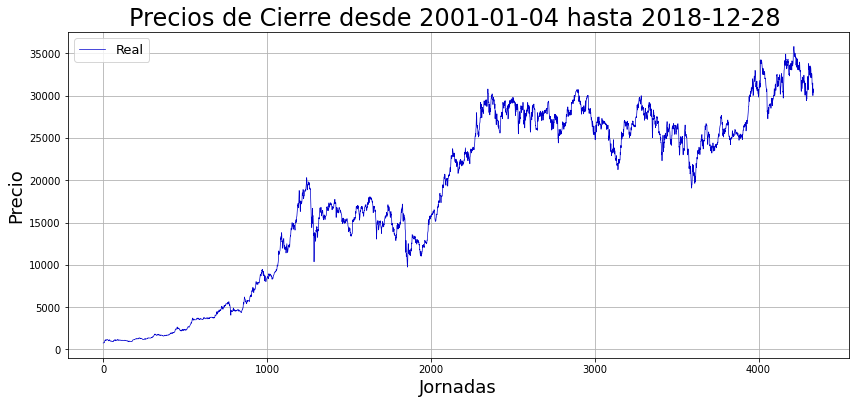

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(data.index,data['PrecioCierre'],color = 'mediumblue', linewidth = 0.7)
plt.title(f"Precios de Cierre desde {data['fecha'][0]} hasta {data['fecha'][4335]} ", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

### Eliminar NAN


In [ ]:
# Eliminar los datos NAN de los datos
dataset = en.delete_nan(dataset)

In [ ]:
dataset

,Volumen,PrecioCierre,PrecioMayor,PrecioMedio,PrecioMenor,adx,moment,macd,rsi,estocastic_D,estocastic_K,ado,dpo,dema,bbands,lbands,obv,nvi,cci
58,8461650,950,950,950.00,950,7.590646,0.0,24.207870,27.536232,0.000000,0.000000,1.640654e+09,-10.95,962.814819,1094.387249,889.512751,2153500293,1299.758321,54.268470
59,4795000,959,959,959.00,959,7.419315,9.0,24.734480,35.897436,2.571429,18.000000,1.640654e+09,16.55,960.332578,1065.089390,901.810610,2158295293,1312.071821,51.364865
60,10384053,916,916,914.98,916,7.265178,-43.0,25.567647,23.140496,2.571429,0.000000,1.640654e+09,27.20,952.785340,1026.505121,919.094879,2147911240,1312.071821,38.247726
61,66780014,930,930,928.95,930,7.081836,14.0,26.267646,31.111111,4.952381,16.666667,1.640654e+09,11.50,947.775592,1021.447143,915.552857,2214691254,1312.071821,43.059904
62,22366000,1000,1000,998.44,1000,6.930963,70.0,25.670805,50.000000,19.238095,100.000000,1.640654e+09,12.30,952.058317,1018.178114,917.221886,2237057254,1410.829915,59.355607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4331,11783960460,31480,31480,31110.63,30000,19.534247,1120.0,21.988185,33.461538,14.144667,38.095238,2.391324e+12,524.00,32060.412657,34170.386347,30701.613653,4792887119971,356.615584,-147.220297
4332,150990000,30000,30000,30000.00,30000,20.534899,-1480.0,96.572028,24.924012,9.042626,0.000000,2.391324e+12,-166.00,31802.334580,34239.184229,30292.815771,4792736129971,339.849667,-199.591444
4333,927504960,30800,30980,30033.84,30000,21.348907,800.0,161.859979,33.062331,9.434242,27.027027,2.391911e+12,234.00,31668.876722,34168.675456,30123.324544,4793663634931,339.849667,-125.342504
4334,1819839820,30640,30800,30505.05,30320,20.607577,-160.0,220.082737,33.888889,12.950726,24.615385,2.392517e+12,410.00,31528.487996,34053.545938,29966.454062,4791843795111,339.849667,-108.862434


### Datos de entrenamiento, validacion y test

In [ ]:
# Filas para entrenamiento
set_train = 3421 # 70%
# Filas para validacion
set_val = 714 # 20%
# Numero de periodos
size_period = 1

In [ ]:
rows = len(dataset.index) #numero de filas del dataset
print("La cantidad de registros son: "+ str(rows)) 
rows_train = set_train # Filas para entrenamiento
rows_validation = set_val #Filas para validacion
print("La cantidad de datos para entrenamiento son: "+ str(rows_train))
print("Los datos de entrenamiento van desde la jornada {0} hasta la {1}".
      format(dataset.index[0],dataset.index[set_train]))
print("La cantidad de datos de validacion es el {0}% de los datos: {1}".
      format(20,rows_validation))
print("La cantidad de datos para test son: "+str(rows-rows_train-rows_validation))
print("Los datos de test van desde la jornada {} hasta la {}".
      format(dataset.index[rows_train+rows_validation],dataset.index[-1]))


La cantidad de registros son: 4278
La cantidad de datos para entrenamiento son: 3421
Los datos de entrenamiento van desde la jornada 58 hasta la 3479
La cantidad de datos de validacion es el 20% de los datos: 714
La cantidad de datos para test son: 143
Los datos de test van desde la jornada 4193 hasta la 4335


In [ ]:
# Datos de entrenamiento
data_train = dataset[:rows_train]
# Datos de validacion
data_val = dataset[rows_train:rows_train+rows_validation]
# Datos de test
data_test = dataset[rows_train+rows_validation:]

### Normalización

$xnorm = \frac{x-min(x)}{max(x)-min(x)}$ 

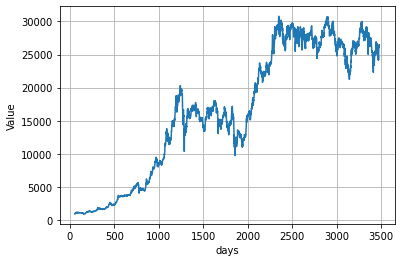

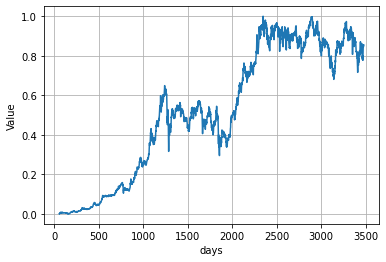

In [ ]:
# Normalizacion
scaler_price = preprocessing.MinMaxScaler() # scaler 
data_train_sc = scaler_price.fit_transform(data_train) # Realiza normalizacion 

data_val_sc = scaler_price.transform(data_val) # normalizacion para validacion
data_test_sc = scaler_price.transform(data_test) # Normalizacion para test


df_train_sc = pd.DataFrame(data_train_sc,index=data_train.index,
                           columns = data_train.columns) #Convierte el entrenamiento a dataframe
df_val_sc = pd.DataFrame(data_val_sc,index=data_val.index,
                           columns = data_val.columns) #Convierte la validacion a dataframe
df_test_sc = pd.DataFrame(data_test_sc,index=data_test.index,
                          columns = data_test.columns) #Convierte a dataframe

gf.plot_series(data_train.index,data_train['PrecioCierre']) #Grafica el entrenamiento normal
plt.show()
gf.plot_series(df_train_sc.index,df_train_sc['PrecioCierre']) # Grafica del train normalizado
plt.show()

In [ ]:
data_desn = scaler_price.inverse_transform(data_test_sc)

In [ ]:
data_desn[:,1]

array([33080., 33120., 33720., 33700., 33780., 33080., 33140., 33600.,
       33540., 33800., 33020., 34100., 34000., 33620., 34060., 33500.,
       33520., 33800., 33800., 34560., 35320., 35420., 35540., 35800.,
       35480., 35000., 35000., 35000., 34600., 34700., 35000., 34720.,
       34680., 34440., 34560., 34540., 33600., 34000., 34440., 34220.,
       33460., 34380., 33320., 34300., 33580., 34000., 34000., 33100.,
       33180., 33020., 33260., 33520., 33560., 33420., 33280., 33080.,
       33000., 33960., 33880., 33400., 32980., 32800., 32960., 32620.,
       32360., 32260., 31500., 30720., 30500., 31160., 30860., 31800.,
       30820., 31280., 31640., 32000., 32180., 31700., 31500., 31480.,
       31720., 31900., 32040., 32040., 32400., 32160., 31560., 31500.,
       31720., 31080., 30260., 30040., 31480., 30880., 30100., 30200.,
       30240., 30500., 30120., 29400., 29420., 29800., 29600., 30280.,
       31000., 31180., 31240., 32000., 32260., 31320., 30680., 31620.,
      

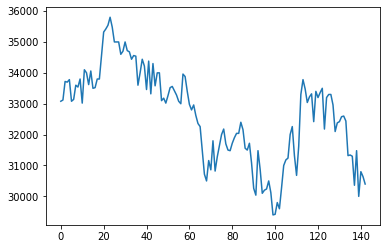

In [ ]:
plt.plot(data_desn[:,1])

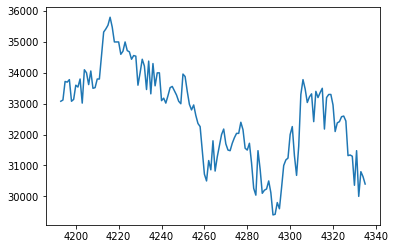

In [ ]:
plt.plot(data_test['PrecioCierre'])

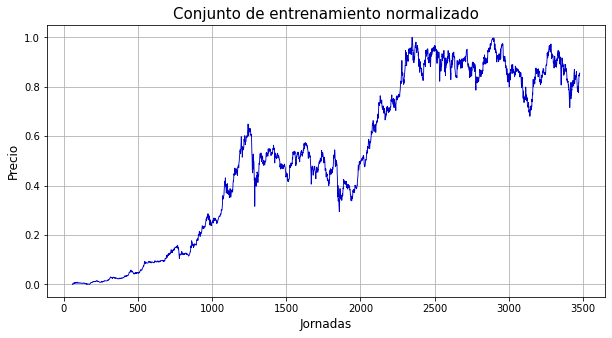

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_train_sc.index,df_train_sc['PrecioCierre'],color = 'mediumblue', linewidth = 0.9)
plt.title(f"Conjunto de entrenamiento normalizado", fontsize=15)
plt.xlabel("Jornadas", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid()

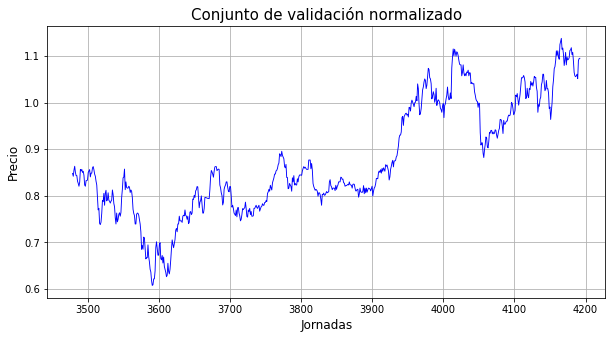

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_val_sc.index,df_val_sc['PrecioCierre'],color = 'blue', linewidth = 0.9)
plt.title(f"Conjunto de validación normalizado", fontsize=15)
plt.xlabel("Jornadas", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid()

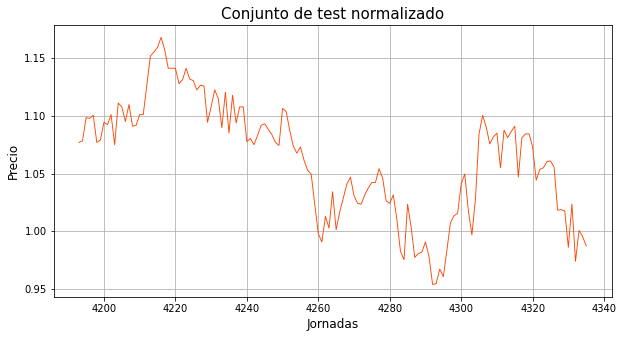

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_test_sc.index,df_test_sc['PrecioCierre'],color = 'orangered', linewidth = 0.9)
plt.title(f"Conjunto de test normalizado", fontsize=15)
plt.xlabel("Jornadas", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid()

###Corrimiento para predicción

In [ ]:
def corr(dataTrain,sizePeriod):
  dataf = dataTrain['PrecioCierre']
  # Periodos que va a realizar de corrimiento
  periodShift = sizePeriod * -1
  dataf = dataf.shift(periods = periodShift)
  # Extraccion de los indicadores
  dataTrain2 = dataTrain.iloc[:,5:19]
  # Vuelve a concatenar las entradas con el precio de cierre
  dataf = pd.concat([dataTrain2,dataf],axis = 1)
  dataf2 = dataf[dataf['PrecioCierre'].notna()]
  return dataf2

In [ ]:
df_train_sf = corr(df_train_sc,size_period) # Corrimiento de 1 al entrenamiento
df_val_sf = corr(df_val_sc,size_period) # corrimiento de 1 a la validacion
df_test_sf = corr(df_test_sc, size_period) # Corrimiento de 1 al test

In [ ]:
if size_period > 1: # Verifica el numero de periodos
  lenRows2 = len(df_train_sf.index)
  print(lenRows2)
  dataFinal = df_train_sf.iloc[:-1,:]
  totalRows = len(dataFinal.index)
# Eliminar la ultima fila

In [ ]:
if size_period > 1: # Cuando el numero de periodos es mayor a 1
  # Conjunto de entrada y de salida
  Entradas = dataFinal.iloc[:,0:5].values
  Salida = dataFinal.iloc[:,5].values
  # Convierte las entradas en 355 filas, cada fila con 5 columnas y cada una con 5 datos
  Entradas2 = np.reshape(Entradas,(int(totalRows/size_period),size_period,size_period))
  print(Entradas2)
  #Convierte la salida en una matriz de 335 filas, una columna cada una de 5 datos.
  Salida2 = np.reshape(Salida,(int(totalRows/size_period),1,size_period))
  print(dataFinal.T)
  #Concatenar las entradas con las salida
  df_train_sf = np.concatenate((Entradas2,Salida2),axis=1)
  # df_train_sf2 = np.reshape(df_train_sf,(335,6,))
  print(df_train_sf[0:2])

In [ ]:
df_test_sf

,adx,moment,macd,rsi,estocastic_D,estocastic_K,ado,dpo,dema,bbands,lbands,obv,nvi,cci,PrecioCierre
4193,0.234373,0.402439,0.409733,0.364468,0.341572,0.383838,1.458591,0.724800,1.086943,1.111261,1.065030,1.423822,-0.090209,0.635531,1.078355
4194,0.222491,0.520325,0.411692,0.350219,0.404991,0.476190,1.446817,0.623811,1.086081,1.110099,1.064252,1.430719,-0.090209,0.649957,1.098446
4195,0.216718,0.634146,0.408755,0.470595,0.511750,0.833333,1.448476,0.484975,1.087792,1.110734,1.064278,1.431837,-0.087557,0.678926,1.097777
4196,0.211780,0.508130,0.403030,0.451910,0.652566,0.985714,1.444923,0.441803,1.089242,1.111179,1.064297,1.429878,-0.087557,0.714844,1.100455
4197,0.211820,0.528455,0.395224,0.529625,0.711730,1.000000,1.446542,0.429251,1.090873,1.111612,1.064259,1.431267,-0.087203,0.694872,1.077016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330,0.244062,0.321138,0.376892,0.302798,0.136004,0.000000,1.435555,0.758273,1.043761,1.096889,1.020173,1.426791,-0.076386,0.425242,1.023440
4331,0.277788,0.739837,0.407133,0.316206,0.141447,0.380952,1.441863,0.702548,1.041053,1.097191,1.016661,1.430269,-0.076386,0.512296,0.973882
4332,0.295725,0.211382,0.443241,0.228468,0.090426,0.000000,1.441863,0.571320,1.032421,1.099465,1.002740,1.430224,-0.083919,0.460646,1.000670
4333,0.310316,0.674797,0.474849,0.312103,0.094342,0.270270,1.442178,0.647394,1.027958,1.097134,0.996968,1.430498,-0.083919,0.533872,0.995312


## Calculo Funcion Objetivo

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def cal_fitness(y_real,y_pred,optimizacion):
  yreal=np.array(y_real)
  ypred=np.array(y_pred)
  valrmse= mean_squared_error(y_real, y_pred, squared=False)

  mae=np.mean(np.abs(yreal-ypred))

  dd=[]
  for x in range(len(yreal)-1):
      if ((yreal[x+1]-yreal[x])*(ypred[x+1]-ypred[x]))<= 0:
          dd.append(0)
      else:
          dd.append(1)
  pocid=np.mean(dd)

  valor_obj = (valrmse + mae)/pocid
  if optimizacion == "maximizar":
    fitness = valor_obj
  elif optimizacion == "minimizar":
    fitness = 1/(1+valor_obj)
  return valor_obj, mae, valrmse, pocid




## Procesamiento de modelo

# Algoritmo genético

## Clase Cromosoma
Esta clase determina las caracteristicas de cada individuo compiladas en un cromosoma. Cada gen es aleatorio entre unos limites superiores e inferiores para cada parametro.
Un cromosoma termina compuesto de la siguiente manera:

[ numero_capas, maximo_neuronas_capa, optimizador, funcion de perdida, tasa de aprendizaje, listado_neuronas, max_neuron_reg]

In [ ]:
class Cromosoma:
  """
  Esta clase crea el cromosoma

  Parametros:

  -- limite inferior de cada variable
  -- limite superior de cada variable
  """


  def __init__(self,limites_inf = None, limites_sup = None, num_var = 5):

    self.num_var = num_var
    self.limites_inf = limites_inf
    self.limites_sup = limites_sup
    self.cromosoma = np.repeat(None, self.num_var)
    self.max_neurons_reg = 200 


    if self.limites_inf is not None \
        and not isinstance(self.limites_inf, np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

    if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
  
  def crear_cromosoma(self):
    '''
    Metodo que se encarga de crear el cromosoma de manera random
    '''
    for i in range(2):
     self.cromosoma[i] = random.randint(self.limites_inf[i],
                                        self.limites_sup[i])
    
    self.learning_rate()
    self.create_neurons()
    self.cromosoma[4] = self.max_neurons_reg

  def learning_rate(self):
    '''
    Creacion de la tasa de aprendizaje de manera uniforme
    '''
    lim_inf = math.log10(self.limites_inf[2]) 
    lim_sup = math.log10(self.limites_sup[2])
    r = lim_inf * np.random.uniform(low = lim_sup/lim_inf , high=1.0) # Numero distibuido
    rand_learning_rate =  10**r
    # Numero entonces entre limites_inf y limites_sup
    self.cromosoma[2] = rand_learning_rate

  def create_neurons(self):
    '''Funcion para crear el numero de neuronas de acuerdo
    al numero de capas'''
    list_neuronas = [] # Contiene el numero de neuronas de cada capa
    list_init_weight = []
    for i in range(0,self.cromosoma[0]):
      numNeuronas = random.randint(1,self.cromosoma[1])
      list_neuronas.append(numNeuronas)
    self.cromosoma[3] = list_neuronas
    

  


## Clase Individuo
Esta clase se encarga de crear el modelo de acuerdo al cromosoma que hereda.
A su vez compila el modelo de acuerdo a los indices de optimizacion y perdida.

In [ ]:
class Individuo(Cromosoma):
  """"
  Esta clase crea el individuo

  Parametros:
  -- Limites inferiores de cada variable
  -- Limites superiores de cada variable
  """

  def __init__(self,limites_inf = None, limites_sup = None):
    super().__init__(limites_inf, limites_sup)

    self.model = None



  def crear_capas(self):
    '''Funcion para crear las capas segun el numero de neuronas y funciones'''
    list_sequential = []
    list_neurons = self.cromosoma[3]
    num_capas = self.cromosoma[0]
    max_neurons_reg = self.cromosoma[4]
    # Decidir si se necesita regularizacion
    sum_neuronas = sum(list_neurons)
    # La indexacion de las neuronas va desde 0 hasta num_capas - 1
    for i in range(0,num_capas-1): 
      
      if sum_neuronas > self.max_neurons_reg:
        list_sequential.append(tf.keras.layers.Bidirectional
                            (tf.keras.layers.LSTM(list_neurons[i],return_sequences=True,
                                                  activation = 'tanh',
                                                  kernel_initializer=initializers
                                                  .glorot_normal(),
                                                  kernel_regularizer = 
                                                  regularizers.l2(l2=0.00000002))))
      else:
        list_sequential.append(tf.keras.layers.Bidirectional
                            (tf.keras.layers.LSTM(list_neurons[i],return_sequences=True,
                                                  activation = 'tanh',
                                                  kernel_initializer=initializers
                                                  .glorot_normal())))
    # Para la ultima capa
    if sum_neuronas > max_neurons_reg:
      list_sequential.append(tf.keras.layers.
                              Bidirectional(tf.keras.layers.LSTM(list_neurons[num_capas-1],
                                                                kernel_initializer=initializers.glorot_normal(),
                                                                kernel_regularizer =  
                                                                regularizers.l2(l2=0.00000002))))
    else:
      list_sequential.append(tf.keras.layers.
                              Bidirectional(tf.keras.layers.LSTM(list_neurons[num_capas-1],
                                                                 kernel_initializer=initializers.glorot_normal()
                                                                )))
    return list_sequential
  
  def create_model(self, inputs_model):
      '''Funcion para crear el modelo funcional'''
      
      list_sequential = self.crear_capas()

      m_input = tf.keras.layers.Input(shape=(inputs_model,1))
      mlayer = list_sequential[0](m_input)
      for i in range(1,len(list_sequential)):
        mlayer = list_sequential[i](mlayer)
      output_layer = tf.keras.layers.Dense(1)(mlayer)

      func_model = Model(inputs = m_input,outputs=output_layer)
      self.model = func_model
    

  def build_opt(self):
    '''Optimizador Adam'''
    learning_rate = self.cromosoma[2]
    
    adam = [optimizers.Adam,4,learning_rate]

    opt = adam[0](adam[2])
    return opt

  def comp_model(self):
    '''Funcion para compilar el modelo'''
    self.model.compile(optimizer= self.build_opt(),
                    loss= losses.Huber(),
                    metrics=['mae'])

## Clase Individuo - Social
Esta clase se encarga de entrenar al individuo, evaluar su desempeño y mutarlo. Hereda el individuo de la clase Individuo.

In [ ]:
class Individuo_social(Individuo):
  cont_individuo = 0
  def __init__(self,limites_inf = None, limites_sup = None):
    super().__init__(limites_inf, limites_sup)

    Individuo_social.cont_individuo += 1

    # historia del entrenamiento
    self.history = None

    # fitness del individuo
    self.fitness = None

    # Valor de la funcion objetivo
    self.valor_obj = None

    # Valor de la prediccion
    self.predict = None

    #Valor entrenamiento
    self.predict_train = None

    # Determinar si realiza mutacion
    self.realiza_mutacion = None

    # Indices de los padres
    self.padres = None

    # herencia de los padres
    self.herencia_padre1 = None
    self.herencia_padre2 = None

    #epocas
    self.epocas = None




  def fit_model(self,tf_train,intEpochs,tf_val, list_callbacks):
    '''
    Entrenar el individuo
    Recibe:
      -- tensor de train
      -- numero de epocas
      -- tensor de validacion
      -- lista de callbacks
    '''
    
    self.history = self.model.fit(tf_train, 
                        epochs = intEpochs,verbose = 0,
                        validation_data = tf_val,
                        callbacks= list_callbacks
                        )
  
  def predict_model(self,x_train,x_test):
    '''
    Prediccion del modelo
    Recibe:
      -- Datos de entrada
    '''
    self.predict = self.model.predict(x_test)
    self.predict_train = self.model.predict(x_train)

  def cal_fitness(self,y_real,y_pred,optimizacion):
    '''evaluacion de la funcion objetivo
    Recibe:
      -- El valor real
      -- El valor salida del modelo de prediccion
      -- la optimizacion: "minimizar" o "maximizar" 
    ''' 
    self.valor_obj = (self.rmse(y_real,y_pred) + 
                      self.mae(y_real, y_pred))/self.pocid(y_real, y_pred)
    if optimizacion == "maximizar":
      self.fitness = self.valor_obj
    elif optimizacion == "minimizar":
      self.fitness = 1/(1+self.valor_obj)

  def rmse (self,yreal,ypred):
    yreal=np.array(yreal)
    ypred=np.array(ypred)
    resta=(yreal-ypred)**2
    media_resta=round(np.median(resta))
    valrmse=math.sqrt(media_resta)
    return valrmse

  def mae(self,yreal,ypred):
    '''funcion para hallar el mae'''
    yreal=np.array(yreal)
    ypred=np.array(ypred)
    mae=np.mean(np.abs(yreal-ypred))
    return mae

  def pocid(self,yreal,ypred):   
    dd=[]
    for x in range(len(yreal)-1):
        if ((yreal[x+1]-yreal[x])*(ypred[x+1]-ypred[x]))<= 0:
            dd.append(0)
        else:
            dd.append(1)

    pocid=np.mean(dd)   
    return pocid

  def mutar(self, prob_mut = 0.1, dist = "normal", media = 0,
            std = 1, min = -1 , max = 1):
    ''' Este metodo se encarga de mutar al individuo, cada gen se ve 
    modificado con una probabilidad definida. Los atributos se reinician al mutar.

    En caso de ser uniforma se escogen el minimo y el maximo.
    En caso contrario media y desviacion estandar 
    '''
    
    mutar_posiciones = np.random.normal( loc = media,
                                        scale = std,
                                         size = self.num_var-1)
    mutar_posiciones = mutar_posiciones < norm.ppf(prob_mut)

    
    if mutar_posiciones[0]:
      mutar_posiciones[3] = True
    else:
      mutar_posiciones[3] = False

    if dist in ["normal", "uniforme"]:
      for i in np.flatnonzero(mutar_posiciones):
        if i < 2:
          if dist == "normal":
            self.cromosoma[i] = np.random.randint(self.limites_inf[i], 
                                                  self.limites_sup[i]+1)
        elif i == 2:
            lim_inf = math.log10(self.limites_inf[i])
            r = lim_inf * np.random.rand() # numero entre -4 y 0
            self.cromosoma[i] =  10**r
        elif i == 3:
            self.create_neurons()

    self.realiza_mutacion = copy.deepcopy(mutar_posiciones)
    # Un vez mutado el cromosoma se contruye el modelo
    self.create_model(14)
    self.comp_model()
  

    
  
  def get_attributes(self):
    return self.history,self.fitness, self.valor_obj

## Clase Poblacion
#### Esta clase crea una poblacion de individuos

In [ ]:
class Poblacion():
  """
  Parametros:

  --- num_individuos: numero de individuos de la poblacion
  --- limites_inf
  --- limites_sup
  """

  def __init__(self, num_individuos, limites_inf = None,
               limites_sup = None):
    self.num_individuos = num_individuos
    self.limites_inf = limites_inf
    self.limites_sup = limites_sup
    self.list_individuos = np.repeat(None, num_individuos)

    self.optimizado = False
    
    # mejor individuo de la poblacion
    self.mejor_individuo = None
    # historio de todos los individuos
    self.historico_individuos = []
    # mejor fit y cromosoma de cada generacion
    self.historico_mejor_fit = []
    self.historico_mejor_cromosoma = []

    # mejores individuos de todo el proceso
    self.campeones = []





    # Creacion de individuos
    for i in range(num_individuos):
      individuo_i = Individuo_social(
          self.limites_inf,
          self.limites_sup
      )
      self.list_individuos[i] = individuo_i

  def creacion_poblacion_inicial(self, num_inputs):
    '''
    Creacion de la poblacion inicial.
    Crea los cromosomas, modelos y la compilacion
    para cada invididuo en la lista.

    Recibe self
    '''
    for individuo in self.list_individuos:
      
      individuo.crear_cromosoma()
      individuo.create_model(num_inputs)
      individuo.comp_model()
      print("-- Se ha creado el individuo con el siguiente cromosoma: ")
      print(f"\t {individuo.cromosoma}")


  def entrenar_pob(self,tf_train,int_epochs,tf_val, callbacks):
    '''
    Entrenamiento de cada individuo de la poblacion.
    Recibe:
      -- Tensor de entrenamiento.
      -- Numero de epocas.
      -- Tensor de validacion.
      -- Lista de callbacks
    '''
    
    for i in range(self.num_individuos):
      tf.keras.backend.clear_session() # Limpia la sesion para que no interfiera
      print("--------------")
      print(f"Entrenamiento del individuo {i+1}")
      print("---------------")
      self.list_individuos[i].fit_model(tf_train,int_epochs,tf_val,callbacks)
      
      mae = self.list_individuos[i].history.history['mae']
      loss = self.list_individuos[i].history.history['loss']

      self.list_individuos[i].epocas = len(loss) # Obtener numero de epocas
  
  def guardar_modelos(self,generacion):
    count = 0
    for individuo in self.list_individuos:
      count += 1
      model_path = f'Resultados_LSTM/Generacion{generacion}/Individuo{count}'
      individuo.model.save(model_path + "/Modelo.h5")

          
     
  
  def evaluar_pob(self,x_test,x_train,yreal, optimizacion):
    '''
    Realiza la predicción y evalua cada individuo 
    de la población.
    Recibe:
      -- Datos de entrada.
      -- Datos reales de la salida para el fitness
      -- optimizacion: "Minimizar" o "Maximizar"
    '''

    for i in range(self.num_individuos):
      self.list_individuos[i].predict_model(x_train,x_test)
      y_pred = self.list_individuos[i].predict
      self.list_individuos[i].cal_fitness(yreal, y_pred, optimizacion)
      print(f"Se ha realizado la prediccion y evaluacion del individuo {i+1}")
      print(f"\t El fitness de {i+1} es {self.list_individuos[i].fitness}")
      print(f"\t Su valor de funcion objetivo es: {self.list_individuos[i].valor_obj}")
    

    
  def extraer_mejores(self,n):
    '''
    Este metodo extrae los mejores n individuos
    de todo el proceso
    '''
    len_historico = len(self.historico_individuos)
    len_historico_j = len(self.historico_individuos[0])
    array_fitness = []
    historico = []
    ubicacion = []
    posicion_campeon = []
    for i in range(len_historico):
      for j in range(len_historico_j):
        ubicacion.append([i,j])
        historico.append(self.historico_individuos[i][j])
        array_fitness.append(
        copy.copy(self.historico_individuos[i][j].fitness))
    
    rango = np.flip(np.argsort(array_fitness))

    for i in rango[:n]:
      posicion_campeon.append(ubicacion[i])
      self.campeones.append(historico[i])
      

    for cam in range(len(posicion_campeon)):
      historico[i].model.save(f"Resultados_LSTM/Campeones/campeon_gen{posicion_campeon[cam][0]} \
                              _ind{posicion_campeon[cam][1]}.h5")
      
    return ubicacion,historico

  def cruce(self, padre1_index, padre2_index):
    '''
    Este metodo se encarga de generar un nuevo individuo o dos segun la
    estrategia de cruce a partir de 2 padres
    '''


    # Se extraen los padres de la lista de individuos
    padre1 = self.list_individuos[padre1_index]
    padre2 = self.list_individuos[padre2_index]

    # Se realiza el clon del cromosoma de uno de los padres para plantilla
    cromosoma_hijo = np.repeat(None, padre1.num_var)

    # seleccion aleatoria de las posiciones
    herencia_padre1 = np.random.choice(
    a = [True, False],
    size = padre1.num_var-1,
    p = [0.5, 0.5],
    replace = True
    )

    herencia_padre2 = np.logical_not(herencia_padre1)

    if herencia_padre1[0]:
      herencia_padre1[3] = True
      herencia_padre2[3] = False
    elif herencia_padre2[0]:
      herencia_padre2[3] = True
      herencia_padre1[3] = False

    # se tranfieren los valores al nuevo individuo

    cromosoma_hijo[0:4][herencia_padre1] = \
         padre1.cromosoma[0:4][herencia_padre1]
    
    cromosoma_hijo[0:4][herencia_padre2] = \
         padre2.cromosoma[0:4][herencia_padre2]
    
    cromosoma_hijo[4] = padre1.cromosoma[4]

    # Creacion del individuo
    hijo = Individuo_social(self.limites_inf, self.limites_sup)
    hijo.cromosoma = copy.deepcopy(cromosoma_hijo)

    hijo.padres = f"p1: {padre1_index} -- p2: {padre2_index}"
    hijo.herencia_padre1 = herencia_padre1
    hijo.herencia_padre2 = herencia_padre2

    # retorna un objeto de tipo individuo_social
    return hijo

  def seleccion(self, num_seleccion,return_indices = True):

    '''
    Este metodo selecciona los mejores individuos de la poblacion
    de acuerdo a su fitness. De manera Torneo
    '''

    #  fitness de cada individuo en un array

    arr_fitness = np.repeat(None, self.num_individuos)
    for i in range(self.num_individuos):
      arr_fitness[i] = self.list_individuos[i].fitness

    # Array del individuo seleccionado
    ind_seleccionado = np.repeat(None, num_seleccion)
    for i in range(num_seleccion):
      # Se escogen dos individuos random de la lista
      candidatos_1 = np.random.choice(
          a = np.arange(self.num_individuos),
          size = 2,
          replace = False
      )
      # Se escogen otros dos
      candidatos_2 = np.random.choice(
          a = np.arange(self.num_individuos),
          size = 2,
          replace = False
      )

      # Compiten los primeros dos
      if arr_fitness[candidatos_1[0]] > arr_fitness[candidatos_1[1]]:
        ganador_1 = candidatos_1[0]
      else:
        ganador_1 = candidatos_1[1]

      #Compiten los otros dos
      if arr_fitness[candidatos_2[0]] > arr_fitness[candidatos_2[1]]:
        ganador_2 = candidatos_2[0]
      else:
        ganador_2 = candidatos_2[1]

     # Compiten los ganadores
      if arr_fitness[ganador_1] > arr_fitness[ganador_2]:
          ind_final = ganador_1
      else:
          ind_final = ganador_2
      # Retorna el indice del ganador y vuelve a escoger segun num_sel    
      ind_seleccionado[i] = ind_final

    return ind_seleccionado

  # -------------------------------------------#
  def crear_nueva_generacion(self,
                             num_inputs = 14,
                             elitismo = 0.1,
                             prob_mut = 0.6,
                             distribucion = "normal",
                             media_dist = 0, std_dist = 1
                             ):
    '''
    Creacion de la nueva generacion.
    Recibe:
      -- numero de entradas del modelo
      -- la probabilidad de elitismo
      -- la probabilidad de muitacion
      -- la distribucion que se realizan los cruces
      -- la media y desviacion de la distribucion
    '''
    # lista para almacenar los individuos
    nuevos_individuos = []

    # ---- Individuos por elitismo ----- #
    if elitismo > 0:
      # Número de individuos que pasan directamente a la siguiente
      # generación.
      n_elitismo = int(np.ceil(self.num_individuos*elitismo))
      print(f"Numero que pasan a la siguiente generacion: {n_elitismo}")

      # Se identifica la elite.
      array_fitness = np.repeat(None, self.num_individuos)
      for i in np.arange(self.num_individuos):
          array_fitness[i] = copy.copy(self.list_individuos[i].fitness)

      # se ordena de menor a mayor y luego se invierten (los indices)
      rango = np.flip(np.argsort(array_fitness))
      
      
      ### PROBLEMA CON EL DEEPCOPY MUY PESADOS LOS MODELOS
      for i in rango[:n_elitismo]:
        old_weights = self.list_individuos[i].model.get_weights()
        elite = Individuo_social(self.limites_inf, self.limites_sup)
        elite.cromosoma = copy.deepcopy(self.list_individuos[i].cromosoma)
        elite.create_model(num_inputs)
        elite.comp_model()
        elite.model.set_weights(old_weights)
        elite.history,elite.fitness, elite.valor_obj = \
        self.list_individuos[i].get_attributes()
        print(f"El individuo {i} paso a la siguiente generacion")

        # Se añaden los individuos élite a la lista de nuevos individuos.
        nuevos_individuos.append(elite)
      
      
    else:
        n_elitismo = 0

    
    
    # -- Crear los individuos por cruces ---
    for i in np.arange(self.num_individuos - n_elitismo):
      # Seleccion de los padres
      indices_padres = self.seleccion(num_seleccion = 2,
                                      return_indices = True)

      # Cruzar los padres para la descendencia
      descendencia = self.cruce(padre1_index = indices_padres[0],
                                      padre2_index = indices_padres[1])
      # Mutacion de la descendencia
      descendencia.mutar(
          prob_mut = prob_mut,
          dist = "normal",
          media = 0,
          std = 1,
          min = -1,
          max = 1
      )
      print("La descendencia ha mutado")
    
      nuevos_individuos.append(descendencia)

    # Actualizar la informacion de la poblacion
    self.list_individuos = np.repeat(None,self.num_individuos)
    self.list_individuos = nuevos_individuos
    print("Se actualizo la lista de individuos de la poblacion")

  # ---------- #

  def optimizacion(self,
                   tf_train,tf_val,
                   callbacks,
                   index_train,
                   index_test,
                   int_epochs,
                   x_train_pd,
                   x_eval,y_real,
                   optimizacion = "minimizar",
                   num_generaciones = 20,
                   elitismo = 0.2,
                   media_distribucion = 0,
                   std_distribucion = 1
                   ):
    '''
    Optimizacion del proceso de algoritmo genetico.
    Recibe:
      -- Tensor de entrenamiento
      -- Tensor de validacion
      -- Datos de entrada para predecir
      -- Valores reales
      -- tipo de optimizacion. Por default: "minimizar"
      -- numero de generaciones
      -- la probabilidad de elitismo
      -- La probabilidad de mutacion
      -- La media de distribucion
      -- Desviacion estandar de distribucion
    '''
    start = time.time()

    # Borrar la carpeta de resultados
    try:
      rmtree("Resultados_LSTM")
    except OSError as e:
      print(f"Error:{ e.strerror}, la carpeta ya existe")
    
    
    
    for i in np.arange(num_generaciones):
      print("Generacion: "+ str(i))
      # Entrenamiento de los individuos
      self.entrenar_pob(tf_train,int_epochs,tf_val,callbacks)
      #Guardar los modelos
      self.guardar_modelos(i)
      # Evaluacion de los individuos
      self.evaluar_pob(x_eval,x_train_pd,y_real,optimizacion)
      # Almacenamiento en los historicos
      self.historico_individuos.append(self.list_individuos)
      prob_mut = 0.5

      self.crear_nueva_generacion(elitismo = elitismo,
                              prob_mut = prob_mut,
                              distribucion = "normal",
                              media_dist = 0, 
                              std_dist = 1,        
      )
      gc.collect()
      
    ubicacion, historico = self.extraer_mejores(4)
    final = time.time()
    self.optimizado = True

    return ubicacion,historico

    # -- Mejor individuo de las generaciones --- #

    
    

# Pruebas con genetico

In [ ]:
import time

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, losses, initializers, regularizers

## Creacion poblacion inicial

In [ ]:
pob_inicial = Poblacion(5, limites_inf=[1,2,0.00001], limites_sup=[3,200,0.001] )

In [ ]:
pob_inicial.creacion_poblacion_inicial(14)  

-- Se ha creado el individuo con el siguiente cromosoma: 
	 [2 196 0.000361674696982546 list([3, 34]) 200]
-- Se ha creado el individuo con el siguiente cromosoma: 
	 [1 41 0.0005195945394492093 list([34]) 200]
-- Se ha creado el individuo con el siguiente cromosoma: 
	 [3 29 0.0002478672004990826 list([14, 25, 13]) 200]
-- Se ha creado el individuo con el siguiente cromosoma: 
	 [2 169 0.00010740123214213802 list([52, 152]) 200]
-- Se ha creado el individuo con el siguiente cromosoma: 
	 [3 74 0.00021787678814499112 list([14, 44, 66]) 200]


## Creación de tensor para los modelos

In [ ]:
# Tamano de la ventana
size_window = 5
# Tamano del batch (Lote)
batch = 16
# Cantidad de datos a preparar (prefetch)
prefetch = 1

In [ ]:
def train_tf(dataSeries, batch, prefetch):
  '''creacion de tensor'''
  dataTensor = tf.data.Dataset.from_tensor_slices(dataSeries) # Pasa a dataset la data
  dataTensor2 = dataTensor.map(lambda window: (window[:-1], window[-1:])) # Mapea como entrada-salida
  dataTensor3= dataTensor2.batch(batch).prefetch(prefetch) # divide en lotes y prefetch
  return dataTensor,dataTensor2,dataTensor3

In [ ]:
tf_train_1,tf_train_2,tf_train_3 = train_tf(df_train_sf,batch,prefetch) # tensor de entrenamiento
tf_val_1,tf_val_2,tf_val_3 = train_tf(df_val_sf,batch,prefetch) # tensor de validacion
tf_test_1,tf_val_2,tf_test_3 = train_tf(df_test_sf,batch,prefetch) # tensor de test

## Callbacks o llamadas a proceso

In [ ]:
callback_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=50, min_delta= 9e-4)

## Datos para ingresar al modelo

In [ ]:
x_train_pd = df_train_sf.iloc[:,0:14].values
y_train_pd = df_train_sf.iloc[:,14].values

x_test_pd = df_test_sf.iloc[:,0:14].values
y_test_pd = df_test_sf.iloc[:,14].values

In [ ]:
index_train = df_train_sf.index
index_test = df_test_sf.index

## Optimización

In [ ]:
ubicacion , historico = pob_inicial.optimizacion(tf_train = tf_train_3,
                                                  tf_val = tf_val_3,
                                                  callbacks = [callback_stopping],
                                                  index_train = index_train,
                                                  index_test  = index_test,
                                                  int_epochs = 2,
                                                  x_train_pd = x_train_pd,
                                                  x_eval = x_test_pd,
                                                  y_real = y_test_pd,
                                                  optimizacion = 'minimizar',
                                                  num_generaciones=7,
                                                  elitismo = 0.1,
                                                  media_distribucion = 0,
                                                  std_distribucion = 1)

Generacion: 0
--------------
Entrenamiento del individuo 1
---------------
--------------
Entrenamiento del individuo 2
---------------
--------------
Entrenamiento del individuo 3
---------------
--------------
Entrenamiento del individuo 4
---------------
--------------
Entrenamiento del individuo 5
---------------
Se ha realizado la prediccion y evaluacion del individuo 1
	 El fitness de 1 es 0.7573388819940811
	 Su valor de funcion objetivo es: 0.32041286110517614
Se ha realizado la prediccion y evaluacion del individuo 2
	 El fitness de 2 es 0.8123190323064676
	 Su valor de funcion objetivo es: 0.23104342041653034
Se ha realizado la prediccion y evaluacion del individuo 3
	 El fitness de 3 es 0.774801225332067
	 Su valor de funcion objetivo es: 0.290653611926616
Se ha realizado la prediccion y evaluacion del individuo 4
	 El fitness de 4 es 0.8455372950159364
	 Su valor de funcion objetivo es: 0.18267994314922828
Se ha realizado la prediccion y evaluacion del individuo 5
	 El fitn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


Se ha realizado la prediccion y evaluacion del individuo 2
	 El fitness de 2 es 0.0
	 Su valor de funcion objetivo es: inf
Se ha realizado la prediccion y evaluacion del individuo 3
	 El fitness de 3 es 0.8229846737217883
	 Su valor de funcion objetivo es: 0.21508945662097725
Se ha realizado la prediccion y evaluacion del individuo 4
	 El fitness de 4 es 0.6594557626915841
	 Su valor de funcion objetivo es: 0.5164019432000664
Se ha realizado la prediccion y evaluacion del individuo 5
	 El fitness de 5 es 0.7980586182164305
	 Su valor de funcion objetivo es: 0.25304078820035203
Numero que pasan a la siguiente generacion: 1
El individuo 0 paso a la siguiente generacion
La descendencia ha mutado
La descendencia ha mutado
La descendencia ha mutado
La descendencia ha mutado
Se actualizo la lista de individuos de la poblacion
Generacion: 2
--------------
Entrenamiento del individuo 1
---------------
--------------
Entrenamiento del individuo 2
---------------
--------------
Entrenamiento del

## Creacion de resultados

In [ ]:
tabla = pd.DataFrame()
tabla['Generacion'] = None
tabla['n_individuo'] = None
tabla['Numero_capas'] = None
tabla['Maximo_neuronas'] = None
tabla['lista neuronas'] = None
tabla['Tasa aprendizaje'] = None
tabla['Maximo reg'] = None
tabla['Vector mutacion'] = None
tabla['padres'] = None
tabla['herencia padre1'] = None
tabla['herencia padre2'] = None
tabla['epocas'] = None
tabla['Funcion Objetivo'] = None

In [ ]:
for i in range(len(ubicacion)):
    list_neuronas = historico[i].cromosoma[3]
    str_list = ", ".join([str(num) for num in list_neuronas])
    nueva_fila = {'Generacion': ubicacion[i][0],
                  'n_individuo': ubicacion[i][1],
                  'Numero_capas': historico[i].cromosoma[0],
                  'Maximo_neuronas': historico[i].cromosoma[1],
                  'lista neuronas': str_list,
                  'Tasa aprendizaje': historico[i].cromosoma[2],
                  'Maximo reg': historico[i].cromosoma[4],
                  'Vector mutacion': historico[i].realiza_mutacion,
                  'padres': historico[i].padres,
                  'herencia padre1': historico[i].herencia_padre1,
                  'herencia padre2': historico[i].herencia_padre2,
                  'epocas': historico[i].epocas,
                  'Funcion Objetivo': historico[i].valor_obj
                
                  }
    tabla = tabla.append(nueva_fila,ignore_index=True)

In [ ]:
2+2

In [ ]:
tabla = crear_tabla(ubicacion,historico)

In [ ]:
tabla

In [ ]:
path_excel = 'Resultados_LSTM/Cuadro_resultados.xlsx'
tabla.to_excel(path_excel)

## Guardar los rendimientos en cada individuo

In [ ]:
fig_path = f'Resultados_LSTM/Figuras_individuo'
os.makedirs(fig_path,
            exist_ok=True)

In [ ]:
for i in range(len(ubicacion)):
  fig = plt.figure(figsize=(14,7))
  (ax1,ax2) = fig.subplots(2)
  ax1.plot(index_train, y_train_pd,color = 'mediumblue', linewidth = 0.7)
  ax1.plot(index_train, historico[i].predict_train,color = 'orangered', linewidth = 0.7)
  ax1.set_title(f"Predicción train Generacion {ubicacion[i][0]} Individuo {ubicacion[i][1]}", fontsize=18)
  ax1.legend(['Real','Prediccion'],fontsize = 10)
  ax2.plot(index_test,y_test_pd,color = 'mediumblue', linewidth = 0.7)
  ax2.plot(index_test, historico[i].predict,color = 'orangered', linewidth = 0.7)
  ax2.set_title(f"Predicción test Generacion {ubicacion[i][0]}  Individuo {ubicacion[i][1]}, \
                Valor Objetivo: {historico[i].valor_obj}", fontsize=18)
  ax2.set_xlabel("Jornadas", fontsize = 12)

  ax2.legend(['Real','Prediccion'],fontsize = 10)
  fig.tight_layout()

  # Guardar las figuras de rendimiento
  
  
  fig.savefig(fig_path+f"/gen{ubicacion[i][0]}_ind{ubicacion[i][1]}.png")

  fig.clf()



In [ ]:
for i in range(len(ubicacion)):
  mae = historico[i].history.history['mae']
  loss = historico[i].history.history['loss']

  path_loss = f'Resultados_LSTM/Generacion{ubicacion[i][0]}/Individuo{ubicacion[i][1]+1}'
  epocas = range(len(loss))
  plt.plot(epocas, mae, 'r')
  plt.plot(epocas, loss, 'b')
  plt.title('MAE and Loss Training')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["MAE", "Loss"])

  plt.savefig(path_loss+"/epocas.png")

  plt.clf()

  


# Prueba con un modelo

In [ ]:
tf.keras.backend.clear_session() # Limpia la sesion para que no interfiera
tf.random.set_seed(51) # Coloca la semilla random para tensorflow
np.random.seed(51) # coloca la semilla random para numpy
random.seed(51) # coloca la semilla para random

### Creación de tensor

In [ ]:
coc_train = len(df_train_sf) % 17
coc_val = len(df_val_sf) % 17
coc_test = len(df_test_sf) % 17

In [ ]:
df_train = df_train_sf.iloc[:-coc_train,:]
df_test = df_test_sf.iloc[:-coc_test,:]
df_val = df_val_sf.iloc[:-coc_val,:]

In [ ]:
# Tamano de la ventana
size_window = 5
# Tamano del batch (Lote)
batch_train = 11 
batch_val = 23
# Cantidad de datos a preparar (prefetch)
prefetch = 1

In [ ]:
x_train_np = df_train.iloc[:,:14].values
y_train_np = df_train.iloc[:,14].values

In [ ]:
x_train_re = x_train_np.reshape(len(x_train_np),1,14)
y_train_re = y_train_np.reshape(len(y_train_np),1)

In [ ]:
x_val = df_val.iloc[:,:14].values
y_val = df_val.iloc[:,14].values
x_val_re = x_val.reshape(len(df_val),1,14)
y_val_re = y_val.reshape(len(df_val),1)

In [ ]:
from tensorflow.python.keras.backend import dropout
m_input = tf.keras.layers.Input(shape=(1,14),batch_size= 17)

m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(190,
                                                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                                        return_sequences=True,
                                                        stateful = True,
                                                        ))(m_input)
m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(195,
                                                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                                        stateful = True,
                                                        ))(m1)

m_output = tf.keras.layers.Dense(1)(m2)

func_model = Model(inputs = m_input,outputs=m_output)

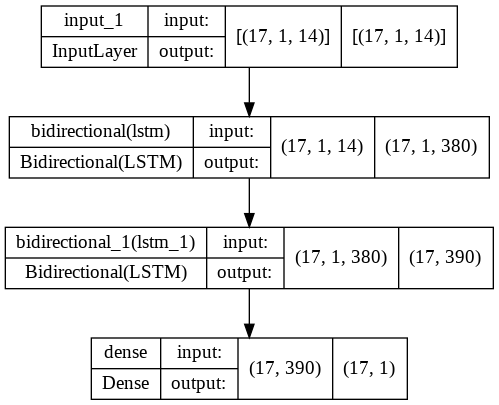

In [ ]:
tf.keras.utils.plot_model(func_model, show_shapes=True)

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate= 0.00003810043743)

In [ ]:
func_model.compile(optimizer=opt,
                  loss=losses.Huber(),
                  metrics=['mae'])

In [ ]:
callback_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=45, min_delta= 9e-4)

In [ ]:
mae = []
loss = []
count = 0

In [ ]:
for i in range(364):
  count += 1
  hist = func_model.fit(x_train_re,y_train_re,batch_size= 17,
                         epochs = 1,verbose = 1)
  mae += hist.history['mae']
  loss += hist.history['loss']
  func_model.reset_states()

In [ ]:
history = func_model.fit(x_train_re,y_train,batch_size= 11, epochs = 364,verbose = 1)

In [ ]:
train_predict = func_model.predict(x_train_re,batch_size =2 )

In [ ]:
train_predict_re = train_predict.reshape(3420,1)

In [ ]:
# Valor funcion objetivo en entrenamiento
valor_obj_train = cal_fitness(y_train_np,train_predict_re,"minimizar")

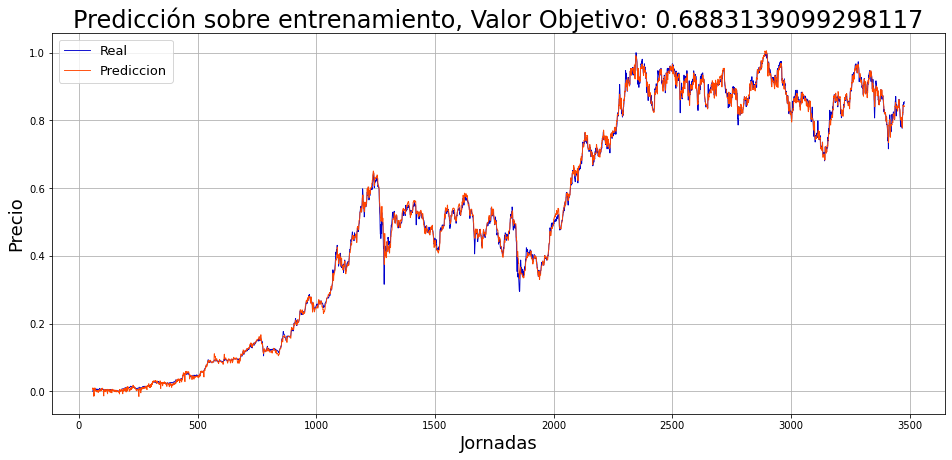

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(df_train_sf.index,y_train_np,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_train_sf.index,train_predict_re,color = 'orangered', linewidth = 0.9)
plt.title(f"Predicción sobre entrenamiento, Valor Objetivo: {valor_obj_train}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

In [ ]:
x_test_np = df_test.iloc[:,0:14].values
y_test_np = df_test.iloc[:,14].values

In [ ]:
x_test_re = x_test_np.reshape(len(x_test_np),1,14)
y_test_re = y_test_np.reshape(len(x_test_np), 1)

In [ ]:
func_model.reset_states()
func_model.reset_metrics()

In [ ]:
test_predict = func_model.predict(x_test_re, batch_size = 17)

In [ ]:
# Valor funcion objetivo en test
valor_obj_test = cal_fitness(y_test_re,test_predict[:,0],"minimizar")

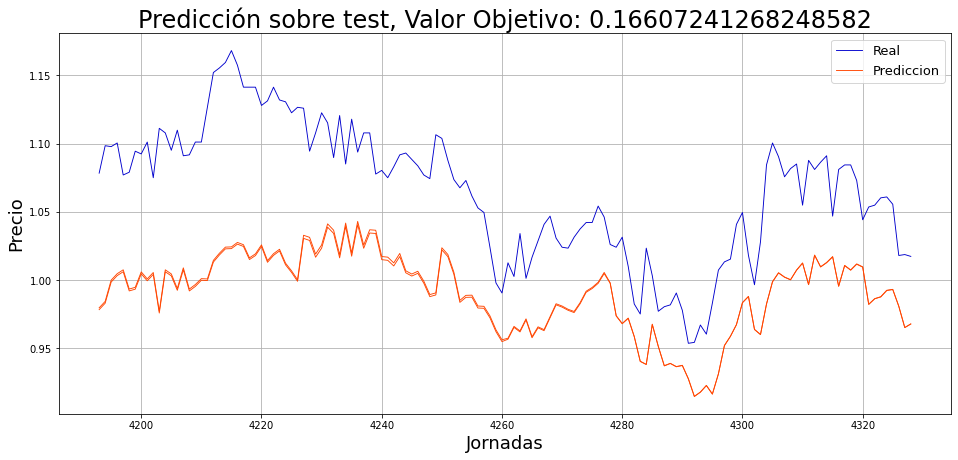

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(df_test.index,y_test_np,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_test.index,test_predict,color = 'orangered', linewidth = 0.9)
plt.title(f"Predicción sobre test, Valor Objetivo: {valor_obj_test}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

In [ ]:
len(loss)

728

<Figure size 432x288 with 0 Axes>

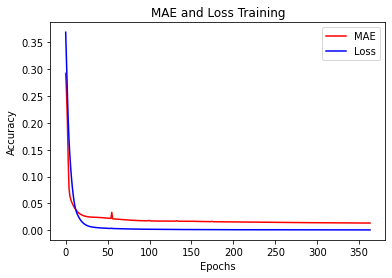

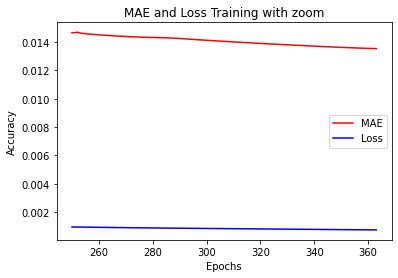

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



# mape = history.history['mape'] 

epochs=range(len(loss)) # Obtener numero de epocas

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss Training')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[250:400]
mae_zoom = mae[250:400]
loss_zoom = loss[250:400]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss Training with zoom')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Carga de modelos

In [ ]:
tf.keras.backend.clear_session() # Limpia la sesion para que no interfiera
tf.random.set_seed(40) # Coloca la semilla random para tensorflow
np.random.seed(40) # coloca la semilla random para numpy
random.seed(40) # coloca la semilla para random

In [ ]:
carga = '/content/drive/MyDrive/ProyectoGrado/Mejores_3/Adadelta/Individuo1/Modelo.h5'

In [ ]:
coc_train = len(df_train_sf) % 17
coc_val = len(df_val_sf) % 17
coc_test = len(df_test_sf) % 17

In [ ]:
coc_train = len(df_train_sf) % 17
coc_val = len(df_val_sf) % 17
coc_test = len(df_test_sf) % 17

In [ ]:
model = load_model(carga)

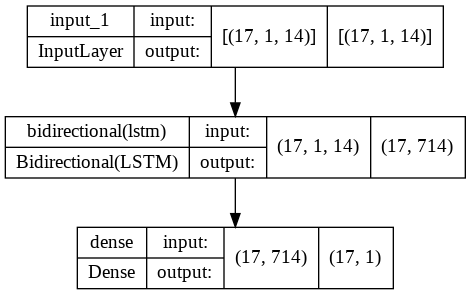

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
weights = model.get_weights()

In [ ]:
model.set_weights(weights)

In [ ]:
coc_train = len(df_train_sf) % 17
coc_val = len(df_val_sf) % 17
coc_test = len(df_test_sf) % 17

In [ ]:
df_train = df_train_sf.iloc[:-coc_train,:]
df_test = df_test_sf.iloc[:-coc_test,:]
df_val = df_val_sf.iloc[:-coc_val,:]

In [ ]:
x_train_np = df_train.iloc[:,:14].values
y_train_np = df_train.iloc[:,14].values

In [ ]:
x_train_re = x_train_np.reshape(len(df_train),1,14)
y_train_re = y_train_np.reshape(len(df_train),1)

In [ ]:
x_val = df_val.iloc[:,:14].values
y_val = df_val.iloc[:,14].values
x_val_re = x_val.reshape(len(df_val),1,14)
y_val_re = y_val.reshape(len(df_val),1)

## Sobre entrenamiento

In [ ]:
model.reset_states()
model.reset_metrics()
train_predict = model.predict(x_train_re, 17)

In [ ]:
# Valor funcion objetivo en entrenamiento
valor_obj_train = cal_fitness(y_train_re,train_predict,"minimizar")[0]

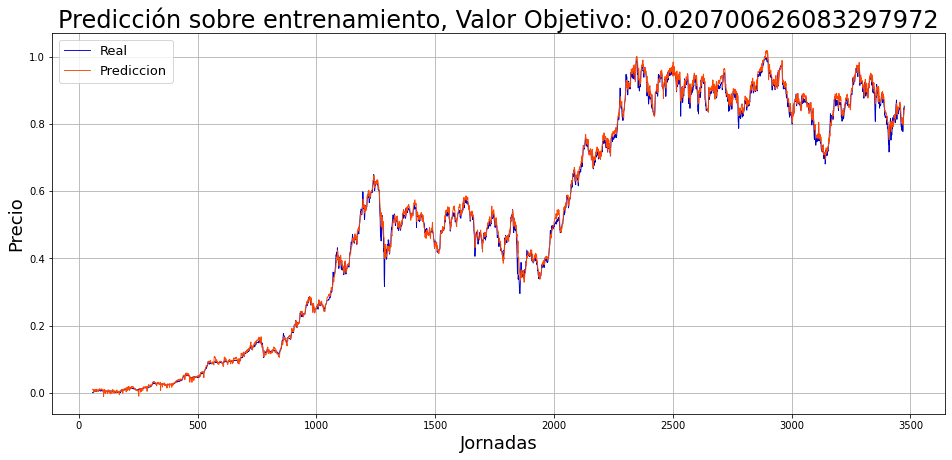

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(df_train.index,y_train_re,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_train.index,train_predict,color = 'orangered', linewidth = 0.9)
plt.title(f"Predicción sobre entrenamiento, Valor Objetivo: {valor_obj_train}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

## Sobre validacion

In [ ]:
model.reset_states()
model.reset_metrics()
val_predict = model.predict(x_val_re,17)

In [ ]:
valor_obj_val = cal_fitness(y_val_re,val_predict,"minimizar")

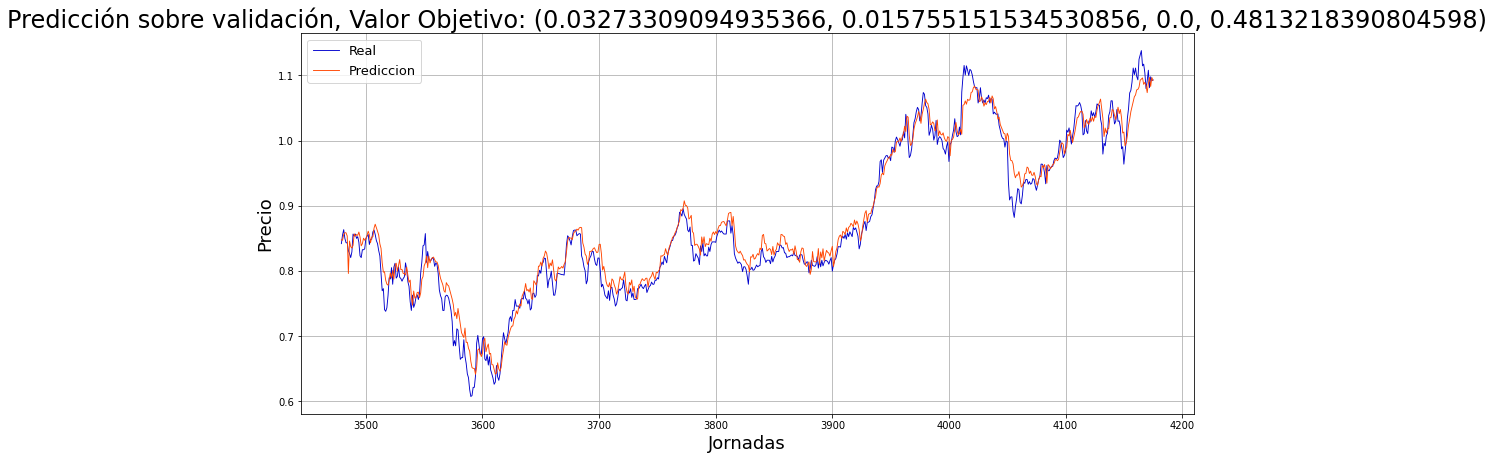

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(df_val.index,y_val_re,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_val.index,val_predict,color = 'orangered', linewidth = 0.9)
plt.title(f"Predicción sobre validación, Valor Objetivo: {valor_obj_val}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

## Sobre test

In [ ]:
x_test_np = df_test.iloc[:,0:14].values
y_test_np = df_test.iloc[:,14].values

In [ ]:
x_test_re = x_test_np.reshape(len(x_test_np),1,14)
y_test_re = y_test_np.reshape(len(x_test_np),1)

In [ ]:
model.reset_states()
model.reset_metrics()
test_predict = model.predict(x_test_re, 17)

In [ ]:
# Valor funcion objetivo en test
valor_obj_test = cal_fitness(y_test_re,test_predict,"minimizar")[0]

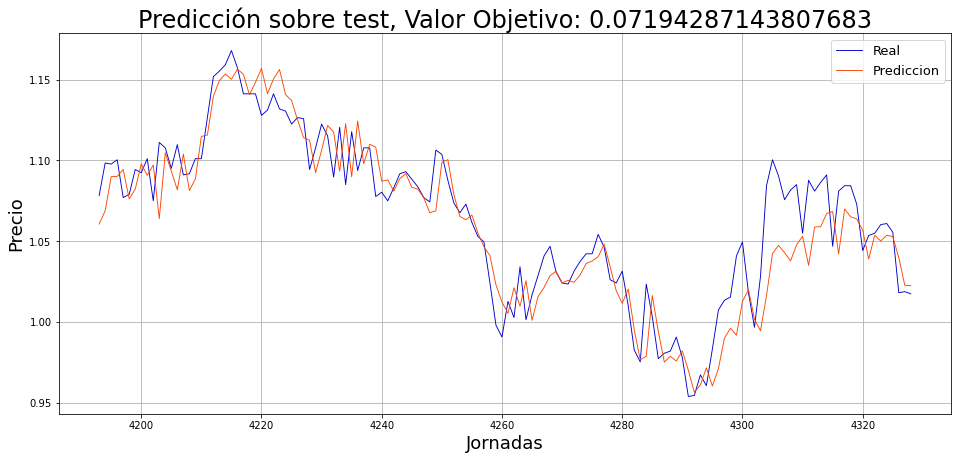

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(df_test.index,y_test_re,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_test.index,test_predict,color = 'orangered', linewidth = 0.9)
plt.title(f"Predicción sobre test, Valor Objetivo: {valor_obj_test}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

In [ ]:
mae_test = cal_fitness(y_test_re,test_predict,"minimizar")[1]
rmse_test = cal_fitness(y_test_re,test_predict,"minimizar")[2]
pocid_test = cal_fitness(y_test_re,test_predict,"minimizar")[3]

In [ ]:
print(mae_test,rmse_test,pocid_test)

0.015356076326936762 0.020348904312701366 0.4962962962962963


In [ ]:
rms = mean_squared_error(y_test_re, test_predict, squared=False)

In [ ]:
rms

0.018406126790979804

# Datos NARX

In [ ]:
path_test = '/content/drive/MyDrive/ProyectoGrado/datos_narx/DatosC3_0005.npy'

In [ ]:
test_narx = np.load(path_test)

In [ ]:
read_file=pd.read_excel(r'/content/drive/MyDrive/ProyectoGrado/DatosNARX_Excel/datos2001C2/2001C2.xlsx') # Lectura del excel
rutaCsv = r"/content/drive/MyDrive/ProyectoGrado/DatosNARX_Excel/datos2001C1/2001C2.csv" # Ruta donde quedara el csv
read_file.to_csv(rutaCsv, index = None, header=True) # Convierte a csv
data_narx = pd.read_csv(rutaCsv) # lectura de csv y lo deja en la ruta

In [ ]:
data_nrx = data_narx.iloc[:,1:]

In [ ]:
data_new = data_nrx.replace({'\[':''}, regex=True)
data_new = data_new.replace({'\]':''}, regex=True)
data_new = data_new.to_numpy()

In [ ]:
for i in range(141):
  for j in range(100):
    data_new[i,j] = float(data_new[i,j])

In [ ]:
ind = 40

In [ ]:
mejor_narx = data_new[:,ind]
mejor_narx = mejor_narx.reshape(141,1)

In [ ]:
valor_obj_test = cal_fitness(test_narx,mejor_narx,"minimizar")[0]

In [ ]:
list_obj = []
for col in range(data_new.shape[1]): 
    data_col = data_new[:, col]
    data_col = data_col.reshape(141,1)
    v_obj =  cal_fitness(test_narx,data_col,"minimizar")[0]
    list_obj.append(v_obj)
np_obj_1 = np.array(list_obj).reshape(100,1)

In [ ]:
rangos = np.flip(np.argsort(list_obj))

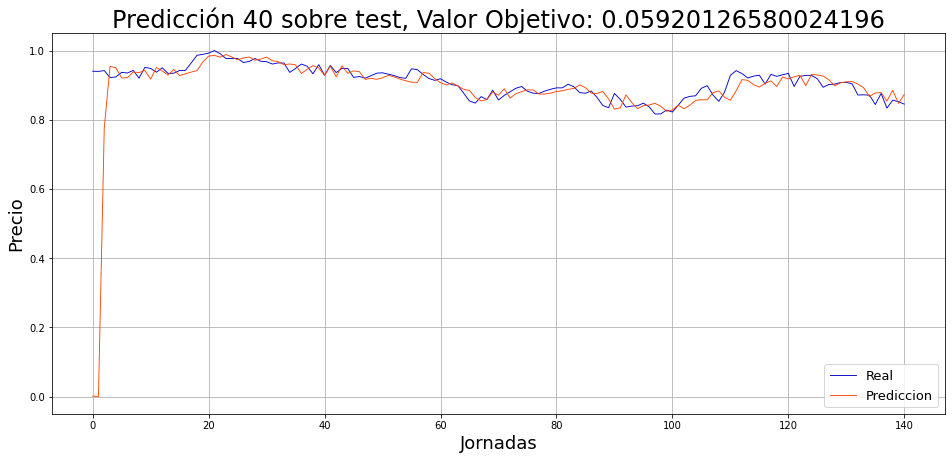

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(data_narx.index,test_narx,color = 'mediumblue', linewidth = 0.9)
plt.plot(data_narx.index,mejor_narx,color = 'orangered', linewidth = 0.9)
plt.title(f"Predicción {ind} sobre test, Valor Objetivo: {valor_obj_test}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

In [ ]:
plt.plot(df_test.index,y_test_re,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_test.index,test_predict,color = 'orangered', linewidth = 0.9)

In [ ]:
real_re =data_train['PrecioCierre'].to_numpy()
real_re = real_re.reshape(-1,1)

In [ ]:
real_re.shape

(3421, 1)

In [ ]:
sc_des = preprocessing.MinMaxScaler() 
data_sc = sc_des.fit_transform(real_re)
date_desnorma_predic= sc_des.inverse_transform(test_predict)

In [ ]:
date_des_test = sc_des.inverse_transform(y_test_re)

In [ ]:
date_des_test.shape

(136, 1)

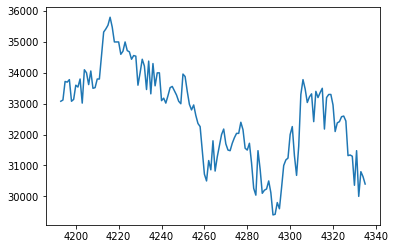

In [ ]:
plt.plot(data_test['PrecioCierre'])

In [ ]:
read_file=pd.read_excel(r'/content/drive/MyDrive/ProyectoGrado/DatosNARX_Excel/output.xlsx') # Lectura del excel
rutaCsv = r"/content/drive/MyDrive/ProyectoGrado/DatosNARX_Excel/output.csv" # Ruta donde quedara el csv
read_file.to_csv(rutaCsv, index = None, header=True) # Convierte a csv
data_des_narx = pd.read_csv(rutaCsv) # lectura de csv y lo deja en la ruta

In [ ]:
data_des_narx = data_des_narx.iloc[:,1]

In [ ]:
data_desn_narx = data_des_narx[:-5]

In [ ]:
filas_index = df_test.index

In [ ]:
index_zoom = filas_index[4:]
date_test_zoom = date_des_test[4:]
lstm_zoom = date_desnorma_predic[4:]
narx_zoom = data_desn_narx[4:]

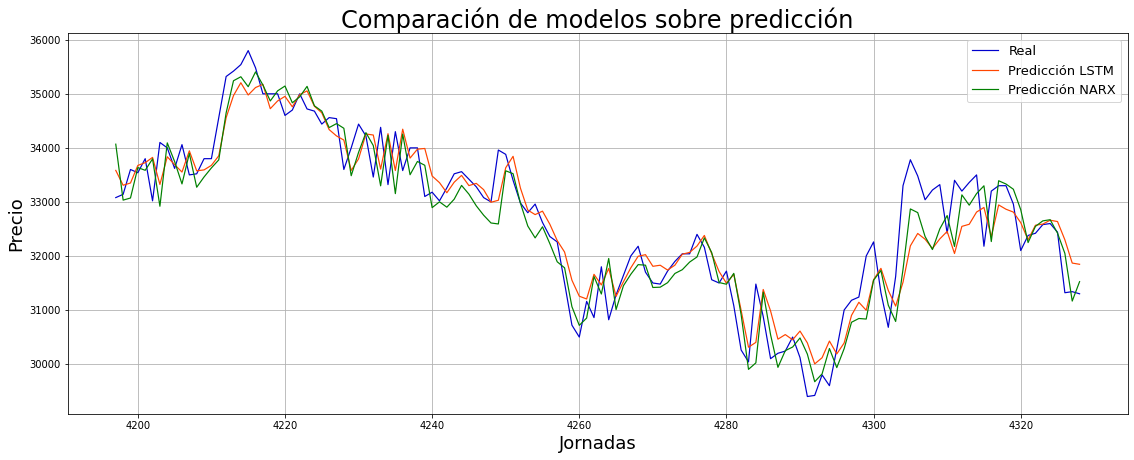

In [ ]:
plt.figure(figsize=(19,7))
plt.plot(index_zoom,date_test_zoom,color = 'mediumblue', linewidth = 1.2)
plt.plot(index_zoom,lstm_zoom,color = 'orangered', linewidth = 1.2)
plt.plot(index_zoom,narx_zoom,color = 'green', linewidth = 1.2)
plt.title(f"Comparación de modelos sobre predicción", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Predicción LSTM','Predicción NARX'],fontsize = 13)
plt.grid()

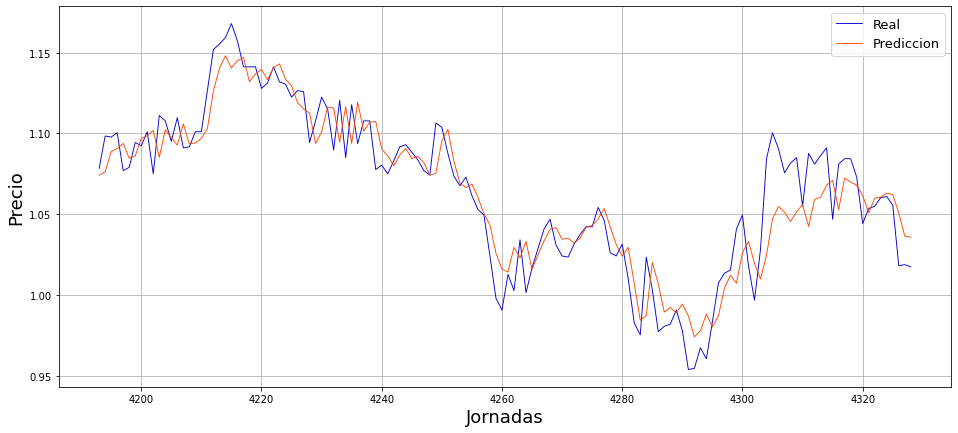

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(df_test.index,y_test_re,color = 'mediumblue', linewidth = 0.9)
plt.plot(df_test.index,test_predict,color = 'orangered', linewidth = 0.9)
# plt.plot(df_test.index,mejor_narx[5:],color = 'green', linewidth = 0.9)
# plt.title(f"Predicción {ind} sobre test, Valor Objetivo: {valor_obj_test}", fontsize=24)
plt.xlabel("Jornadas", fontsize=18)
plt.ylabel("Precio", fontsize=18)
plt.legend(['Real','Prediccion'],fontsize = 13)
plt.grid()

# Evaluación de modelos

## Normalidad de los datos

## Correlacion

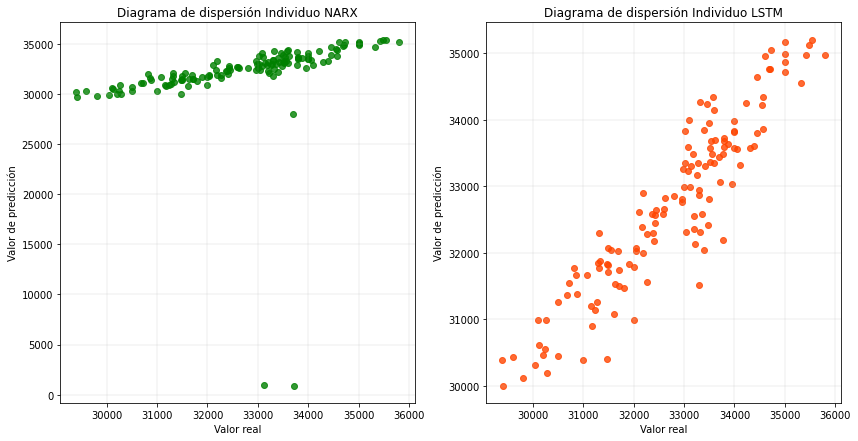

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].scatter(x=date_des_test, y=data_desn_narx , alpha= 0.8, color='green')
ax[0].set_title('Diagrama de dispersión Individuo NARX')
ax[0].set_xlabel('Valor real')
ax[0].set_ylabel('Valor de predicción')
ax[0].grid(linewidth=0.2)

ax[1].scatter(x=date_des_test, y=date_desnorma_predic, alpha= 0.8, color='orangered')
ax[1].set_title('Diagrama de dispersión Individuo LSTM')
ax[1].set_xlabel('Valor real')
ax[1].set_ylabel('Valor de predicción')
ax[1].grid(linewidth=0.2)

In [ ]:
!pip install pingouin

In [ ]:
import statsmodels.api as sm
import pingouin as pg
from scipy import stats
from scipy.stats import pearsonr

In [ ]:
list_real = y_test_re.flatten()
list_pred = test_predict.flatten()

In [ ]:
list_pred = np.array(list_pred, dtype='float64')

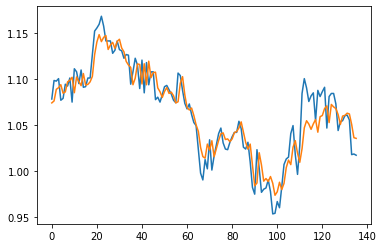

In [ ]:
plt.plot(list_real)
plt.plot(list_pred)
plt.show()

(array([ 4.,  9., 12., 16., 17., 19., 30., 13., 11.,  5.]),
 array([0.95379052, 0.975221  , 0.99665149, 1.01808197, 1.03951246,
        1.06094294, 1.08237343, 1.10380391, 1.1252344 , 1.14666488,
        1.16809537]),
 <a list of 10 Patch objects>)

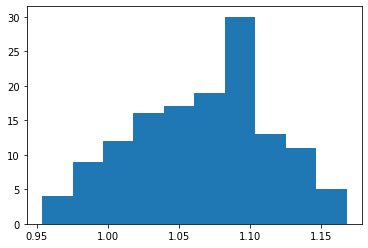

In [ ]:
plt.hist(list_real)

In [ ]:
display(pg.corr(list_real,list_pred, method='pearson'))
display(pg.corr(list_real,list_pred, method='spearman'))
display(pg.corr(list_real,list_pred, method='kendall'))

,n,r,CI95%,p-val,BF10,power
pearson,136,0.927412,"[0.9, 0.95]",4.375753e-59,2.616e+55,1.0


,n,r,CI95%,p-val,power
spearman,136,0.917271,"[0.89, 0.94]",1.983251e-55,1.0


,n,r,CI95%,p-val,power
kendall,136,0.762531,"[0.68, 0.82]",1.936983e-39,1.0


## MAE, POCID y RMSE

In [ ]:
mae_test = cal_fitness(list_real,list_pred,"minimizar")[1]

In [ ]:
rmse_test = cal_fitness(list_real,list_pred,"minimizar")[2]

In [ ]:
pocid_test = cal_fitness(list_real,list_pred,"minimizar")[3]

In [ ]:
print(f"{mae_test}\n{rmse_test}\n{pocid_test}")

0.029600632900120997
0.0
0.5


In [ ]:
obj = (mae_test + rmse_test)/pocid_test
print(obj)

0.059201265800241994


## Coeficiente de determinación

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
plt.plot(data_narx.index,test_narx,color = 'mediumblue', linewidth = 0.9)
plt.plot(data_narx.index,mejor_narx,color = 'orangered', linewidth = 0.9)

In [ ]:
r2_des = r2_score(test_narx, mejor_narx)

In [ ]:
n, p = 141, 14

In [ ]:
r2_adj = 1 - ((1 - r2_des)*((n - 1)/(n-p-1)))

In [ ]:
r2_des

-6.074397239990951

In [ ]:
r2_adj

-6.860441377767724